In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import numpy as np
import regex as reg

%matplotlib inline  

Extracting references from texts:

In [ ]:
!python ./Scripts/reference_extraction.py 

Loading references as previously extracted:

In [2]:
references = pd.read_csv('data/References.csv', index_col=0)

In [3]:
references.head()

,ref,file,ref_parsed,year,identifier
0,"Lave, J., & Wenger, E. (1991). Situated learni...",import2018_371,"Lave, J., & Wenger, E. (1991)",1991.0,"Lave, J., & Wenger, E. (1991). Situated learni..."
1,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",import2018_371,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",2013.0,"Miles, M. B., Huberman, A. M., & Saldana, J. (..."
2,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",import2018_371,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",1997.0,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish..."
3,"Rogoff, B. (1995). Observing sociocultural act...",import2018_371,"Rogoff, B. (1995)",1995.0,"Rogoff, B. (1995). Observing sociocultural act..."
4,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",import2018_371,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",2012.0,"Shirk, J., Ballard, H., Wilderman, C., Phillip..."


Some sample references, and their corresponding identifier:

In [ ]:
sample = references[['ref', 'identifier']].sample(4)
[print("ref: ",r, '\nidentifier: ', s,) for r, s in zip(sample.ref.tolist(), sample.identifier.tolist())]

### First we check the most cited citations:

In [ ]:
plt.title('Most cited references')
references.identifier.value_counts().head(20).plot(kind='bar')
references.identifier.value_counts().head(10)

### We look at how the references are distributed over the years:

In [ ]:
references.year.plot(kind='box')

### Looking at authors in dataset & the ones they reference

Load the metadata:

In [ ]:
metadata = pd.read_csv('data/Parsed_metadata.csv', index_col=0)

In [ ]:
reference_authors = pd.read_csv('data/Reference_authors.csv', index_col=0)
reference_authors.shape

In [ ]:
reference_authors.drop_duplicates(inplace=True)
reference_authors.shape

In [ ]:
reference_authors.head()

We check the most cited author:

In [ ]:
plt.title('Most cited authors')
reference_authors.author.value_counts().head(15).plot(kind='bar')

In [ ]:
plt.title('Most cited for reference after 2010')
reference_authors[reference_authors.year > 2010].author.value_counts().head(15).plot(kind='bar')

We now merge on the shortened name as it can be found in the citation.

**Note** that we might get illegitemate merges, as the short name is not unique, even within the metadata dataset!

In [ ]:
reference_edges = pd.merge(metadata, reference_authors, on='file')

reference_edges.sample(2)

In [ ]:
reference_edges.rename(columns={'shortend_names': 'author', 'author': 'cited'}, inplace=True)

#### Self citations:

In [ ]:
reference_edges[reference_edges.author == reference_edges.cited].author.value_counts().head()

### Number of authors in and out of conference

In and out of conference citations, quick calculation:

In [ ]:
print('Number of distinct authors ', len(reference_edges.author.unique()))
print('Number of distinct cited authors by some author in the conference ', len(reference_edges.cited.unique()))
print('Number of authors that where cited by an other author in the confernce :' , len(set(reference_edges.cited.tolist()).intersection(set(reference_edges.author.tolist()))))

In [ ]:
reference_edges = reference_edges[['cited', 'author', 'year', 'ref']][reference_edges.year.notna()]

In [ ]:
match_conference = ' JLS |Journal of the Learning Sciences|CSCL|ICLS|ijCSCL|Computer Supported Collaborative Learning'
re.search(match_conference,'bjfejf ICLS')

In [ ]:
mask_c_s = reference_edges.ref.map(lambda x: True if re.search(match_conference, x) else False)

In [ ]:
in_conference = set(reference_edges[mask_c_s].cited.unique())

We limit the range of years to get people that are still "active"

In [ ]:
not_in_conference = list(set(reference_edges[reference_edges.year > 2010].cited) - in_conference.union(set(reference_edges.author)))

In [ ]:
#todo: filter out organisations
# todo: deal with non overlapping names
plt.title('Most cited authors that have not participated in conference')
plt.ylabel('number of times cited')
reference_edges[reference_edges.cited.isin(not_in_conference)].cited.value_counts().head(20).plot(kind = 'bar')

In [ ]:
reference_edges[(reference_edges.cited.isin(not_in_conference)) & (reference_edges.cited == 'Goodwin C.')].ref.sample(4).tolist()

In [ ]:
reference_edges[(reference_edges.cited.isin(not_in_conference)) & (reference_edges.cited == 'Gee J. P.')].ref.sample(4).tolist()

# extract conference, journal etc:

In [4]:
text = references.sample().ref.item()
reg.split(r'\. (?=[\p{Lu}][\p{L}])', text)

['Moolenaar, N. M., Sleegers, P. J., & Daly, A. J. (2012)',
 'Teaming up: Linking collaboration networks, collective efficacy, and student achievement',
 'Teaching and Teacher Education, 28(2), 251–262.']

In [5]:
#regex to find journals or conferences
re.search('(P|p)roceedings|(j|J)ournal', text)

In [6]:
match_conference = ' JLS |Journal of the Learning Sciences|CSCL|ICLS|ijCSCL|Computer Supported Collaborative Learning'
match_conference.lower()

' jls |journal of the learning sciences|cscl|icls|ijcscl|computer supported collaborative learning'

In [181]:
def clean_string(x):
    x = x.lower()
    x = re.sub('[\'\"\”\/\–]*', '', x)
    x = re.sub(' & ', ' and ', x)
    #x = re.sub(' th | nd | rd | st | volume |\-|\—|  ', ' ', x)
    x = re.sub(' on ', ' of ', x)
    x = x.strip()
    return x

mask = references.ref.map(lambda x: True if 
                          (re.search('(C|c)onference|(P|p)roceedings|(j|J)ournal|(T|t)ransactions', x) and not
                          re.search(match_conference.lower(), clean_string(x))) else False)

In [182]:
sources = references[mask].ref.map(lambda x: 
                            [y for y in reg.split(r'\. (?=[\p{Lu}][\p{L}])', x) 
                             if re.search('(C|c)onference|(P|p)roceedings|(j|J)ournal|(T|t)ransactions', y)
                            ][0])

In [183]:
sources.shape

(3446,)

In [184]:
sources[14589]

'In The first international conference on Computer support for collaborative learning (pp. 67-74). L'

In [185]:
sources = sources.map(lambda x: clean_string(x))

In [186]:
sources = sources.map(lambda x: [y.strip() for y in reg.split(r'\.|\,|\?|\;|\(|\)', x) 
                                 if re.search('conference|proceedings|journal|transactions', y)][0])


People like to misspell CSCL spell it in various forms..

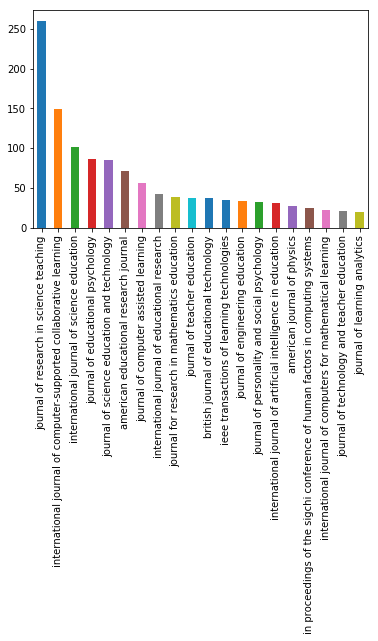

In [187]:
sources.value_counts().head(20).plot(kind='bar')

In [188]:
sources.value_counts().shape

(1265,)

## Try to make individual conference stop list:

In [189]:
import nltk
from nltk import word_tokenize

In [190]:
nltk.pos_tag(['second'], tagset='universal')

[('second', 'ADJ')]

In [191]:
from collections import Counter

In [192]:
all_words = []
all_tags = []

for sentence in sources:
    s = word_tokenize(sentence)
    all_words += s
    all_tags += [ y for x,y in nltk.pos_tag(s)]

In [193]:
dict_all_words = dict((x,all_words.count(x)) for x in set(all_words))

In [194]:
word_df = pd.DataFrame([all_words,all_tags]).T
word_df.columns = ['word', 'tag']

In [195]:
word_df.tag.value_counts()

NN      8853
IN      5035
JJ      3820
NNS     1868
DT      1064
CC       659
CD       594
VBG      413
:        186
VBN      182
VBD       66
VBZ       24
VBP       22
FW        20
$         17
NNP       17
VB        14
JJR       14
TO        10
RB         5
SYM        4
PRP        4
PRP$       4
MD         1
WDT        1
.          1
Name: tag, dtype: int64

In [207]:
word_df[word_df.tag == 'JJR'].word.value_counts()

higher     13
teacher     1
Name: word, dtype: int64

In [180]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [112]:
import difflib
difflib.SequenceMatcher(None, 'hello', 'hello').ratio()

1.0

In [99]:
d = {}

In [100]:
for i, row in enumerate(sources.unique()):
    for j, row_2 in enumerate(sources.unique()):
        if i > j and row != row_2:
            difference = difflib.SequenceMatcher(None, row, row_2).ratio()
            if difference > 0.9:
                if row in d.keys():
                    d[row].append(row_2)
                else:
                    d[row] = [row_2]

In [101]:
len(d)

232

In [102]:
d

{'acm conference of computer supported cooperative work': ['of acm conference of computer supported cooperative work'],
 'acm transactions of computer human interactions': ['acm transactions of computer human interaction',
  'transactions of computer human interaction'],
 'acm transactions of human–computer interaction': ['acm transactions of human– computer interaction',
  'ais transactions of human computer interaction'],
 'ais transactions of human computer interaction': ['acm transactions of human– computer interaction'],
 'american education research journal': ['american educational research journal'],
 'american journal education': ['american journal of education'],
 'american journal of evaluation': ['american journal of education'],
 'american journal of psychology': ['american journal of sociology',
  'interamerican journal of psychology'],
 'australasian journal educational technology': ['australasian journal of educational technology'],
 'australian journal of teacher educat

In [ ]:
sources